### Parameter

In [1]:
# WORD-level
MAX_NUM_WORDS     = 15000
EMBEDDING_DIM     = 300
MAX_SEQ_LENGTH    = 500
USE_GLOVE         = True
KERNEL_SIZES      = [3,4,5]
FEATURE_MAPS      = [200,200,200]

# CHAR-level
USE_CHAR          = False
ALPHABET          = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
ALPHABET_SIZE     = len(ALPHABET)
CHAR_MAX_LENGTH   = 1600
CHAR_KERNEL_SIZES = [5,10,20]
CHAR_FEATURE_MAPS = [200,200,200]

# GENERAL
DROPOUT_RATE      = 0.4
HIDDEN_UNITS      = 200
NB_CLASSES        = 2

# LEARNING
BATCH_SIZE        = 100
NB_EPOCHS         = 10
RUNS              = 5
VAL_SIZE          = 0.2

### Preprocessing

In [2]:
import os
import re
import string
from nltk.corpus import stopwords

def clean_doc(doc):
    """
    Cleaning a document by several methods:
        - Lowercase
        - Removing whitespaces
        - Removing numbers
        - Removing stopwords
        - Removing punctuations
        - Removing short words
    """
    #stop_words = set(stopwords.words('english'))
    
    # Lowercase
    doc = doc.lower()
    # Remove numbers
    #doc = re.sub(r"[0-9]+", "", doc)
    # Split in tokens
    tokens = doc.split()
    # Remove Stopwords
    #tokens = [w for w in tokens if not w in stop_words]
    # Remove punctuation
    #tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    # Tokens with less then two characters will be ignored
    #tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)


def read_files(path):
    documents = list()
    
    # Read in all files in directory
    if os.path.isdir(path):
        for filename in os.listdir(path):
            with open('%s/%s' % (path, filename)) as f:
                doc = f.read()
                doc = clean_doc(doc)
                documents.append(doc)
    
    # Read in all lines in one file
    if os.path.isfile(path):        
        with open(path, encoding='iso-8859-1') as f:
            doc = f.readlines()
            for line in doc:
                documents.append(clean_doc(line))
                
    return documents

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

## Sentence polarity dataset v1.0
#negative_docs = read_files('data/rt-polaritydata/rt-polarity.neg')
#positive_docs = read_files('data/rt-polaritydata/rt-polarity.pos')
#X = negative_docs + positive_docs
#y = [0 for _ in range(len(negative_docs))] + [1 for _ in range(len(positive_docs))]

## IMDB
train_fasion_mnist = tfds.as_numpy(tfds.load("imdb_reviews", split="train", batch_size=-1))
X, y = [clean_doc(x.decode()) for x in train_fasion_mnist["text"]], train_fasion_mnist["label"]

test_fasion_mnist  = tfds.as_numpy(tfds.load("imdb_reviews", split="test", batch_size=-1))
X_test, y_test     = [clean_doc(x.decode()) for x in test_fasion_mnist["text"]], test_fasion_mnist["label"]

print('Training samples:', len(X))

Training samples: 25000


### Preprocessing for word-based model

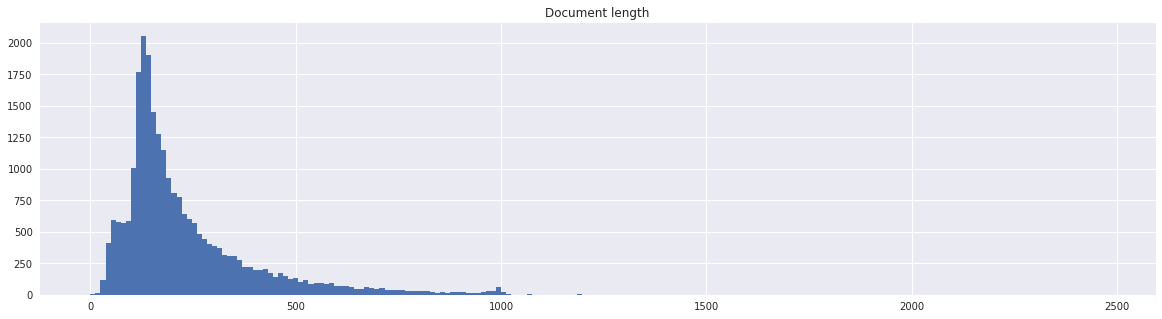

Text informations:
max length: 2470 / min length: 10 / mean length: 233 / limit length: 500


In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index

result = [len(x.split()) for x in X]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title('Document length')
plt.hist(result, 200, density=False, range=(0,np.max(result)))
plt.show()


print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result), np.min(result),
                                                                                np.mean(result), MAX_SEQ_LENGTH))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
word_data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

### Preprocessing for char-based model

In [5]:
if USE_CHAR:
    char2idx_dict = {}
    idx2char_dict = {}

    for idx, char in enumerate(ALPHABET):
        char2idx_dict[char] = idx + 1

    idx2char_dict = dict([(i+1, char) for i, char in enumerate(char2idx_dict)])
    
    # Get informations about char length
    result = [len(x) for x in X]
    plt.figure(figsize=(20,5))
    plt.title('Char length')
    plt.hist(result, 200, density=False, range=(0,np.max(result)))
    plt.show()
    print('Text informations:')
    print('max: %i / min: %i / mean: %i / limit: %i'%(np.max(result),np.min(result),np.mean(result),CHAR_MAX_LENGTH))

In [6]:
def char_vectorizer(X):
    str2idx = np.zeros((len(X), CHAR_MAX_LENGTH), dtype='int64')
    for idx, doc in enumerate(X):
        max_length = min(len(doc), CHAR_MAX_LENGTH)
        for i in range(0, max_length):
            c = doc[i]
            if c in char2idx_dict:
                str2idx[idx, i] = char2idx_dict[c]
    return str2idx

### Embeddings

In [7]:
def create_glove_embeddings():
    print('Pretrained embedding GloVe is loading...')

    embeddings_index = {}
    with open('glove.6B.%id.txt' % EMBEDDING_DIM) as glove_embedding:
        for line in glove_embedding.readlines():
            values = line.split()
            word   = values[0]
            coefs  = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Found %s word vectors in GloVe embedding\n' % len(embeddings_index))

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        
        if i >= MAX_NUM_WORDS:
            continue
        
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return tf.keras.layers.Embedding(
        input_dim=MAX_NUM_WORDS,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQ_LENGTH,
        weights=[embedding_matrix],
        trainable=True,
        name="word_embedding"
    )

### Training

In [ ]:
from cnn_model import CNN
from sklearn.model_selection import train_test_split

histories = []

for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    random_state = np.random.randint(1000)
    
    X_train, X_val, y_train, y_val = train_test_split(word_data, tf.keras.utils.to_categorical(y),
                                                      test_size=VAL_SIZE, random_state=random_state)
    
    if USE_CHAR:
        X_train_c, X_val_c, _, _ = train_test_split(char_vectorizer(X), tf.keras.utils.to_categorical(y), 
                                                    test_size=VAL_SIZE, random_state=random_state)
        X_train = [X_train, X_train_c]
        X_val   = [X_val,   X_val_c]
    
        
    emb_layer = None
    if USE_GLOVE:
        emb_layer = create_glove_embeddings()
    
    model = CNN(
        embedding_layer   = emb_layer,
        num_words         = MAX_NUM_WORDS,
        embedding_dim     = EMBEDDING_DIM,
        kernel_sizes      = KERNEL_SIZES,
        feature_maps      = FEATURE_MAPS,
        max_seq_length    = MAX_SEQ_LENGTH,
        use_char          = USE_CHAR,
        char_max_length   = CHAR_MAX_LENGTH,
        alphabet_size     = ALPHABET_SIZE,
        char_kernel_sizes = CHAR_KERNEL_SIZES,
        char_feature_maps = CHAR_FEATURE_MAPS,
        dropout_rate      = DROPOUT_RATE,
        hidden_units      = HIDDEN_UNITS,
        nb_classes        = NB_CLASSES
    ).build_model()
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.optimizers.Adam(),
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                'model-%i.h5'%(i+1), monitor='val_loss', verbose=1, save_best_only=True, mode='min'
            ),
        ]
    )

    histories.append(history.history)

Running iteration 1/5
Pretrained embedding GloVe is loading...
Found 400000 word vectors in GloVe embedding

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
19900/20000 [============================>.] - ETA: 0s - loss: 0.4851 - accuracy: 0.7489
Epoch 00001: val_loss improved from inf to 0.35185, saving model to model-1.h5
20000/20000 [==============================] - 93s 5ms/sample - loss: 0.4843 - accuracy: 0.7494 - val_loss: 0.3518 - val_accuracy: 0.8528
Epoch 2/10
19900/20000 [============================>.] - ETA: 0s - loss: 0.2662 - accuracy: 0.8919
Epoch 00002: val_loss improved from 0.35185 to 0.25206, saving model to model-1.h5
20000/20000 [==============================] - 90s 5ms/sample - loss: 0.2663 - accuracy: 0.8920 - val_loss: 0.2521 - val_accuracy: 0.8972
Epoch 3/10
19900/20000 [============================>.] - ETA: 0s - loss: 0.1902 - accuracy: 0.9256
Epoch 00003: val_loss improved from 0.25206 to 0.24667, saving model to model-1.h5
20000/20000 [========

### Evaluation

In [9]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc'   % (get_avg(histories,'loss'), get_avg(histories,'accuracy')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories,'val_loss'), get_avg(histories,'val_accuracy')))

Training: 	0.1813 loss / 0.9307 acc
Validation: 	0.2415 loss / 0.9042 acc


In [10]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

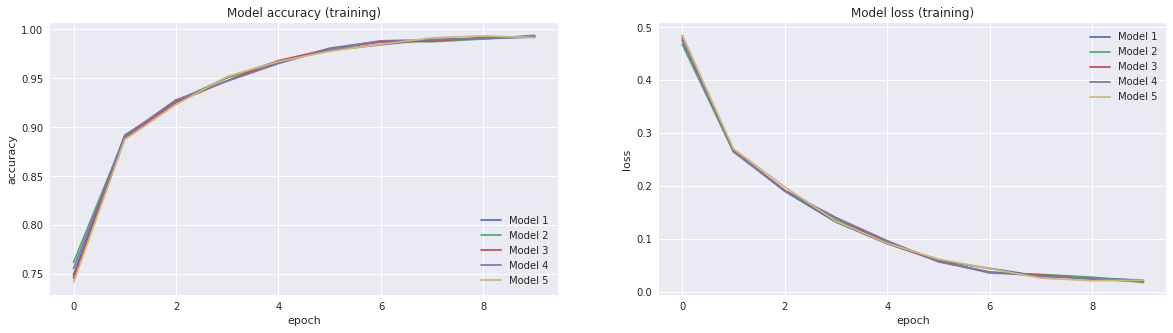

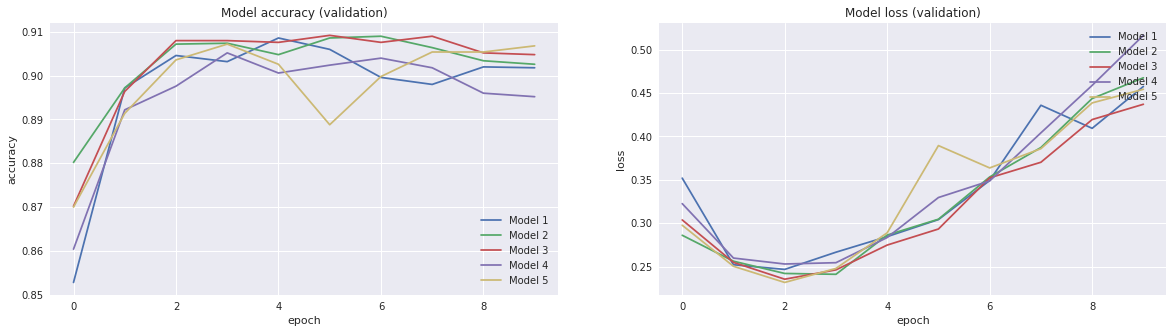

In [11]:
plot_acc_loss('training', histories, 'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')

#### Final test (IMDB / Yelp)

In [12]:
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_word    = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=MAX_SEQ_LENGTH, padding='post')

if USE_CHAR:
    X_test_word = [X_test_word, char_vectorizer(X_test)]
else:
    X_test_word = X_test_word

In [13]:
import cnn_model

test_loss = []
test_accs = []

for i in range(0,RUNS):
    cnn_ = tf.keras.models.load_model("model-%i.h5" % (i+1))
    score = cnn_.evaluate(X_test_word, tf.keras.utils.to_categorical(y_test), verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])
    print('Running test with model %i: %0.4f loss / %0.4f acc' % (i+1, score[0], score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.4f acc' % (np.mean(test_loss),np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))

Running test with model 1: 0.2480 loss / 0.8984 acc
Running test with model 2: 0.2466 loss / 0.9048 acc
Running test with model 3: 0.2371 loss / 0.9028 acc
Running test with model 4: 0.2526 loss / 0.8981 acc
Running test with model 5: 0.2384 loss / 0.9036 acc

Average loss / accuracy on testset: 0.2445 loss / 0.9016 acc
Standard deviation: (+-0.0059) loss / (+-0.0028) acc


___________________
# Scikit Example

#### Define Vectorizer

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(
    ngram_range  = (1,2),
    min_df       = 0.0005,
    max_df       = 0.1,
    lowercase    = False,
    preprocessor = None,
    sublinear_tf = True, 
    use_idf      = True,
)

#### Define Model

In [15]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(
    max_iter            = 1000, 
    tol                 = 1e-3,
    validation_fraction = 0.2
)

#### Define Pipeline

In [16]:
from sklearn.pipeline import Pipeline

ml_classifier = Pipeline([
    ('vectorizer', tf_idf),
    ('classifier', sgd)
])

#### Train the classifier

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SIZE)
ml_classifier.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.1, max_features=None, min_df=0.0005,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smoot..._state=None, shuffle=True, tol=0.001,
       validation_fraction=0.2, verbose=0, warm_start=False))])

In [18]:
val_pred = ml_classifier.predict(X_val)
print('Accuracy:', np.mean(y_val==val_pred))

Accuracy: 0.9078


#### Inspect important features by extracting coefs

Extracted features: 66504


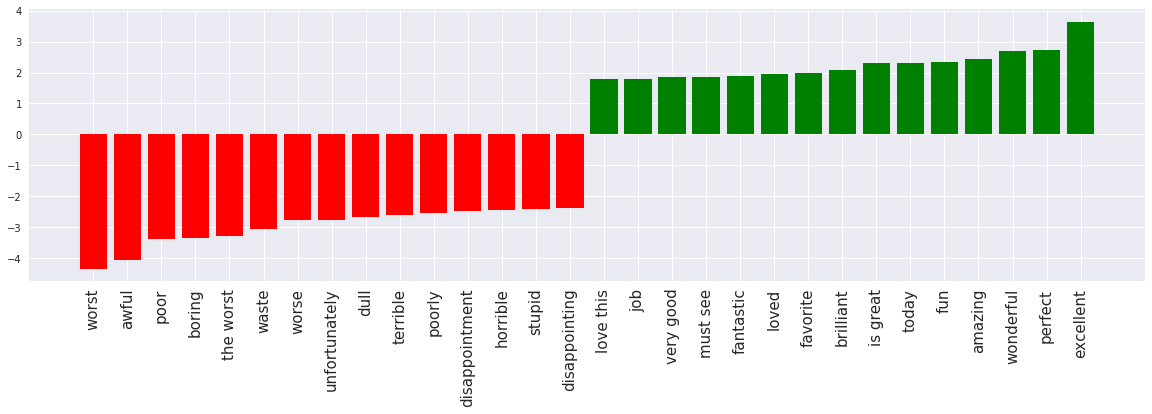

In [19]:
nb_neg_features = 15
nb_pos_features = 15

feature_names = ml_classifier.get_params()['vectorizer'].get_feature_names()
coef = ml_classifier.get_params()['classifier'].coef_.ravel()

print('Extracted features: {}'.format(len(feature_names)))

pos_coef = np.argsort(coef)[-nb_pos_features:]
neg_coef = np.argsort(coef)[:nb_neg_features]
interesting_coefs = np.hstack([neg_coef, pos_coef])

# Plot
plt.figure(figsize=(20, 5))
colors = ['red' if c < 0 else 'green' for c in coef[interesting_coefs]]
plt.bar(np.arange(nb_neg_features + nb_pos_features), coef[interesting_coefs], color=colors)
feature_names = np.array(feature_names)
plt.xticks(np.arange(nb_neg_features+nb_pos_features),feature_names[interesting_coefs],size=15,rotation=90,ha='center');
plt.show()

#### Final evaluation

In [20]:
preds = ml_classifier.predict(X_test)
print('Accuracy:', np.mean(y_test==preds))

Accuracy: 0.90184
